# Загружаем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import simfin as sf

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable 

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [5]:
#SimFin data

balance = pd.read_csv('data/balance.csv')
prices = pd.read_csv('data/prices.csv')

# Подготовка данных

Заполняем пропуски, убираем даты, для которых нет фундаментальных показателей

In [6]:
comp_balance = balance[balance['Ticker'] == 'MSFT'].drop(columns=['Ticker', 'SimFinId'])
comp_balance = comp_balance.rename(columns={'Report Date' : 'Date'})
comp_price = prices[prices['Ticker'] == 'MSFT'].drop(columns=['Ticker', 'SimFinId'])

data = pd.merge(comp_price, comp_balance, on='Date', how='outer')
data = data.dropna(subset=['Open'])
dividend = data['Dividend']

data = data.drop(columns=['Dividend'])

data = data.interpolate(method='linear')
data = data.drop(columns=['Treasury Stock', 'Currency', 'Fiscal Year', 'Fiscal Period', 'Publish Date', 'Restated Date'])
data = data.dropna()
#Логично дивиденды заполнить нулями, так как их не было
data['Dividend'] = dividend.fillna(0)
data = data.reset_index()
data = data.drop(columns=['index', 'Shares (Basic)', 'Shares (Diluted)', 'Volume'])
data['Date'] = data['Date'].apply(lambda dt: datetime.datetime.strptime(dt, "%Y-%m-%d").strftime("%d.%m.%Y"))

In [7]:
data

,Date,Open,Low,High,Close,Adj. Close,Shares Outstanding,"Cash, Cash Equivalents & Short Term Investments",Accounts & Notes Receivable,Inventories,...,Short Term Debt,Total Current Liabilities,Long Term Debt,Total Noncurrent Liabilities,Total Liabilities,Share Capital & Additional Paid-In Capital,Retained Earnings,Total Equity,Total Liabilities & Equity,Dividend
0,30.06.2009,23.97,23.63,24.24,23.77,18.29,8.908000e+09,3.144700e+10,1.119200e+10,7.170000e+08,...,2.000000e+09,2.703400e+10,3.746000e+09,1.129600e+10,3.833000e+10,6.238200e+10,-2.282400e+10,3.955800e+10,7.788800e+10,0.0
1,01.07.2009,24.05,23.96,24.30,24.04,18.50,8.908000e+09,3.152952e+10,1.115130e+10,7.237656e+08,...,2.003906e+09,2.706098e+10,3.746000e+09,1.130136e+10,3.836234e+10,6.238061e+10,-2.279677e+10,3.958384e+10,7.794619e+10,0.0
2,02.07.2009,23.76,23.21,24.04,23.37,17.98,8.908000e+09,3.161203e+10,1.111059e+10,7.305312e+08,...,2.007812e+09,2.708797e+10,3.746000e+09,1.130672e+10,3.839469e+10,6.237922e+10,-2.276953e+10,3.960969e+10,7.800438e+10,0.0
3,06.07.2009,23.21,22.87,23.28,23.20,17.85,8.908000e+09,3.169455e+10,1.106989e+10,7.372969e+08,...,2.011719e+09,2.711495e+10,3.746000e+09,1.131208e+10,3.842703e+10,6.237783e+10,-2.274230e+10,3.963553e+10,7.806256e+10,0.0
4,07.07.2009,23.08,22.46,23.14,22.53,17.34,8.908000e+09,3.177706e+10,1.102919e+10,7.440625e+08,...,2.015625e+09,2.714194e+10,3.746000e+09,1.131744e+10,3.845938e+10,6.237644e+10,-2.271506e+10,3.966138e+10,7.812075e+10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2700,23.03.2020,137.01,132.52,140.57,135.98,134.61,7.606047e+09,1.342530e+11,2.352500e+10,1.823000e+09,...,6.247000e+09,5.964000e+10,6.336100e+10,1.130450e+11,1.726850e+11,7.962500e+10,3.048400e+10,1.101090e+11,2.827940e+11,0.0
2701,24.03.2020,143.75,141.27,149.60,148.34,146.85,7.606047e+09,1.342530e+11,2.352500e+10,1.823000e+09,...,6.247000e+09,5.964000e+10,6.336100e+10,1.130450e+11,1.726850e+11,7.962500e+10,3.048400e+10,1.101090e+11,2.827940e+11,0.0
2702,25.03.2020,148.91,144.44,154.33,146.92,145.44,7.606047e+09,1.342530e+11,2.352500e+10,1.823000e+09,...,6.247000e+09,5.964000e+10,6.336100e+10,1.130450e+11,1.726850e+11,7.962500e+10,3.048400e+10,1.101090e+11,2.827940e+11,0.0
2703,26.03.2020,148.40,148.37,156.66,156.11,154.54,7.606047e+09,1.342530e+11,2.352500e+10,1.823000e+09,...,6.247000e+09,5.964000e+10,6.336100e+10,1.130450e+11,1.726850e+11,7.962500e+10,3.048400e+10,1.101090e+11,2.827940e+11,0.0


In [8]:
data.columns

Index(['Date', 'Open', 'Low', 'High', 'Close', 'Adj. Close',
       'Shares Outstanding', 'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Inventories', 'Total Current Assets',
       'Property, Plant & Equipment, Net',
       'Long Term Investments & Receivables', 'Other Long Term Assets',
       'Total Noncurrent Assets', 'Total Assets', 'Payables & Accruals',
       'Short Term Debt', 'Total Current Liabilities', 'Long Term Debt',
       'Total Noncurrent Liabilities', 'Total Liabilities',
       'Share Capital & Additional Paid-In Capital', 'Retained Earnings',
       'Total Equity', 'Total Liabilities & Equity', 'Dividend'],
      dtype='object')

# Порисуем графики

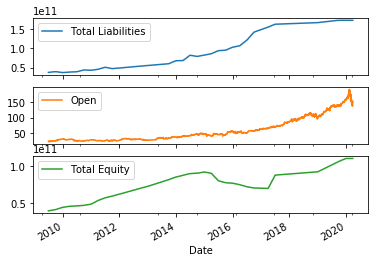

In [9]:
date_time = pd.to_datetime(data['Date'], format='%d.%m.%Y')

plot_cols = ['Total Liabilities', 'Open', 'Total Equity']
plot_features = data[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

In [10]:
data = data.set_index('Date')
dim = len(data.columns)
data['Target'] = (data['Low'] + data['High'])*0.5
X = data.iloc[:, :-1]
X = X.iloc[:-1]
y = data.iloc[:, -1:]
y = y.iloc[1:]

In [11]:
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 


X_train = X_ss[:2300, :]
X_test = X_ss[2300:, :]

y_train = y_mm[:2300, :]
y_test = y_mm[2300:, :]


X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 


X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

In [12]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 


Training Shape torch.Size([2300, 1, 26]) torch.Size([2300, 1])
Testing Shape torch.Size([404, 1, 26]) torch.Size([404, 1])


# Построение модели

In [13]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, linear_dim):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        self.linear_dim = linear_dim #dim of linear layers

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, linear_dim) #fully connected 1
        self.fc = nn.Linear(linear_dim, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out
 

# Обучение

In [14]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = dim #number of features
hidden_size = 4 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
linear_dim = 128 #dim of linear layers

num_classes = 1 #number of output classes 

In [15]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1], linear_dim) #our lstm class 
lstm1
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 


In [16]:
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
 
    loss.backward() #calculates the loss of the loss function
 
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 


Epoch: 0, loss: 0.04527
Epoch: 100, loss: 0.00036
Epoch: 200, loss: 0.00019
Epoch: 300, loss: 0.00015
Epoch: 400, loss: 0.00012
Epoch: 500, loss: 0.00010
Epoch: 600, loss: 0.00009
Epoch: 700, loss: 0.00007
Epoch: 800, loss: 0.00006
Epoch: 900, loss: 0.00005


In [17]:
df_X_ss = ss.transform(data.iloc[:, :-1]) #old transformers
df_y_mm = mm.transform(data.iloc[:, -1:]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 


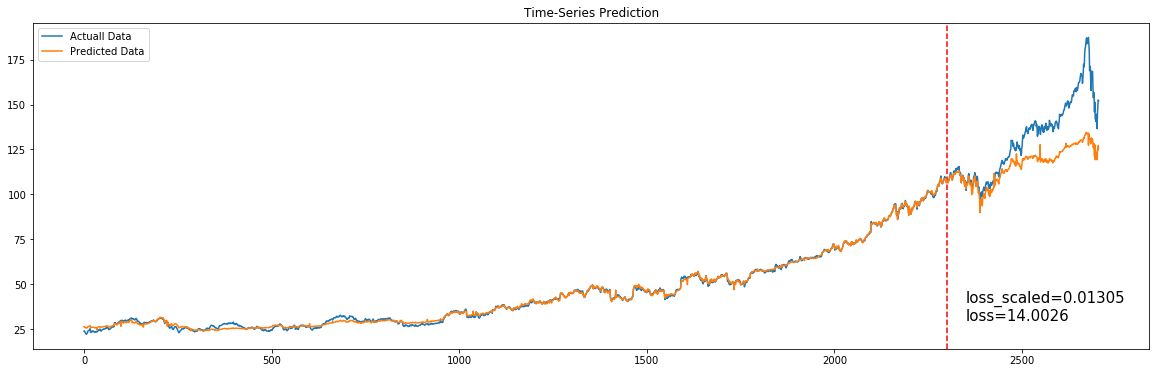

In [18]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

outputs = lstm1.forward(X_test_tensors_final)
loss = criterion(outputs, y_test_tensors)
mse = loss.item()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

mse_scaled=0
for i in range(len(dataY_plot)-2300):
    mse_scaled += abs(dataY_plot[2300+i][0] - data_predict[2300+i][0])
mse_scaled /= len(dataY_plot)-2300

plt.figure(figsize=(20,6)) #plotting
plt.axvline(x=2300, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.text(2350, 30, 'loss='+str(mse_scaled)[:7], fontsize=15)
plt.text(2350, 40, 'loss_scaled='+str(mse)[:7], fontsize=15)
plt.legend()
plt.show() 

# Подбор параметров.

In [19]:
df_X_ss = ss.transform(data.iloc[2300:-1, :-1]) #old transformers
df_y_mm = mm.transform(data.iloc[2301:, -1:]) #old transformers


df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 


results = []
for ld in [16, 32, 64, 128, 256]:
    for hs in [4, 8, 16, 32]:
        lstm1 = LSTM1(num_classes, input_size, hs, num_layers, X_train_tensors_final.shape[1], ld) #our lstm class
        criterion = torch.nn.MSELoss()    # mean-squared error for regression
        optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 
        
        for epoch in range(num_epochs):
            outputs = lstm1.forward(X_train_tensors_final) #forward pass
            optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
            # obtain the loss function
            loss = criterion(outputs, y_train_tensors)
 
            loss.backward() #calculates the loss of the loss function
 
            optimizer.step() #improve from loss, i.e backprop
     
        outputs = lstm1.forward(X_test_tensors_final)
        loss = criterion(outputs, y_test_tensors)
        loss.backward()
        mse = loss.item()
        results.append([int(ld), int(hs), mse])
        print("linear_dim = %d | hidden_size = %d | mse = %1.5f" % (ld, hs, mse))
        

linear_dim = 16 | hidden_size = 8 | mse = 0.02345
linear_dim = 16 | hidden_size = 16 | mse = 0.02063
linear_dim = 16 | hidden_size = 32 | mse = 0.00724
linear_dim = 32 | hidden_size = 8 | mse = 0.02785
linear_dim = 32 | hidden_size = 16 | mse = 0.01144
linear_dim = 32 | hidden_size = 32 | mse = 0.00953
linear_dim = 64 | hidden_size = 8 | mse = 0.00602
linear_dim = 64 | hidden_size = 16 | mse = 0.00525
linear_dim = 64 | hidden_size = 32 | mse = 0.00551
linear_dim = 128 | hidden_size = 8 | mse = 0.02044
linear_dim = 128 | hidden_size = 16 | mse = 0.00326
linear_dim = 128 | hidden_size = 32 | mse = 0.00171


In [20]:
res_df = pd.DataFrame(results, columns =['ld', 'hs', 'mse'])
best = res_df[res_df.mse == res_df.mse.min()]
print(best)
best = best.to_numpy()

     ld  hs       mse
11  128  32  0.001713


In [21]:
lstm1 = LSTM1(num_classes, input_size, int(best[0][1]), num_layers, X_train_tensors_final.shape[1], int(best[0][0])) #our lstm class 
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [22]:
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 


Epoch: 0, loss: 0.01690
Epoch: 100, loss: 0.00012
Epoch: 200, loss: 0.00006
Epoch: 300, loss: 0.00002
Epoch: 400, loss: 0.00001
Epoch: 500, loss: 0.00001
Epoch: 600, loss: 0.00001
Epoch: 700, loss: 0.00001
Epoch: 800, loss: 0.00001
Epoch: 900, loss: 0.00001


In [23]:
df_X_ss = ss.transform(data.iloc[:, :-1]) #old transformers
df_y_mm = mm.transform(data.iloc[:, -1:]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

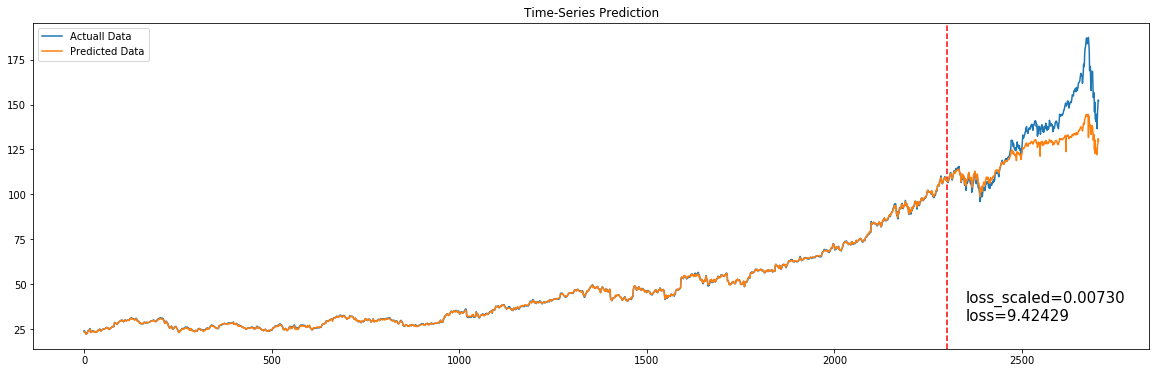

In [24]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

outputs = lstm1.forward(X_test_tensors_final)
loss = criterion(outputs, y_test_tensors)
loss.backward()
mse = loss.item()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

mse_scaled=0
for i in range(len(dataY_plot)-2300):
    mse_scaled += abs(dataY_plot[2300+i][0] - data_predict[2300+i][0])
mse_scaled /= len(dataY_plot)-2300

plt.figure(figsize=(20,6)) #plotting
plt.axvline(x=2300, c='r', linestyle='--') #size of the training set



plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.text(2350, 30, 'loss='+str(mse_scaled)[:7], fontsize=15)
plt.text(2350, 40, 'loss_scaled='+str(mse)[:7], fontsize=15)
plt.legend()
plt.show() 

# Обработка данных 2

Оставим только наиболее значимые и некоррелирующие признаки

In [25]:
comp_balance = balance[balance['Ticker'] == 'MSFT'].drop(columns=['Ticker', 'SimFinId'])
comp_balance = comp_balance.rename(columns={'Report Date' : 'Date'})
comp_price = prices[prices['Ticker'] == 'MSFT'].drop(columns=['Ticker', 'SimFinId'])

data = pd.merge(comp_price, comp_balance, on='Date', how='outer')
data = data.dropna(subset=['Open'])
dividend = data['Dividend']

data = data.drop(columns=['Dividend', 'Currency', 'Fiscal Period', 'Publish Date', 'Restated Date'])
#
data = data.interpolate(method='linear', limit_direction='forward', axis=0)
data = data.drop(columns=['Treasury Stock'])

data = data.dropna()
#Логично дивиденды заполнить нулями, так как их не было
data['Dividend'] = dividend.fillna(0)
data = data.reset_index()
data = data.drop(columns=['index', 'Fiscal Year', 'Shares (Basic)', 'Shares (Diluted)', 'Volume'])
data = data.drop(columns=['Inventories', 'Share Capital & Additional Paid-In Capital', 'Payables & Accruals', 'Shares Outstanding', 'Accounts & Notes Receivable', 'Close'])
data = data.drop(columns=['Property, Plant & Equipment, Net', 'Long Term Investments & Receivables', 'Other Long Term Assets', 'Total Noncurrent Assets', 'Total Current Assets'])
data = data.drop(columns=['Total Noncurrent Liabilities', 'Total Current Liabilities', 'Total Liabilities & Equity', 'Short Term Debt', 'Long Term Debt', 'Dividend', 'Adj. Close'])
data['Date'] = data['Date'].apply(lambda dt: datetime.datetime.strptime(dt, "%Y-%m-%d").strftime("%d.%m.%Y"))

In [26]:
data

,Date,Open,Low,High,"Cash, Cash Equivalents & Short Term Investments",Total Assets,Total Liabilities,Retained Earnings,Total Equity
0,30.06.2009,23.97,23.63,24.24,3.144700e+10,7.788800e+10,3.833000e+10,-2.282400e+10,3.955800e+10
1,01.07.2009,24.05,23.96,24.30,3.152952e+10,7.794619e+10,3.836234e+10,-2.279677e+10,3.958384e+10
2,02.07.2009,23.76,23.21,24.04,3.161203e+10,7.800438e+10,3.839469e+10,-2.276953e+10,3.960969e+10
3,06.07.2009,23.21,22.87,23.28,3.169455e+10,7.806256e+10,3.842703e+10,-2.274230e+10,3.963553e+10
4,07.07.2009,23.08,22.46,23.14,3.177706e+10,7.812075e+10,3.845938e+10,-2.271506e+10,3.966138e+10
...,...,...,...,...,...,...,...,...,...
2700,23.03.2020,137.01,132.52,140.57,1.342530e+11,2.827940e+11,1.726850e+11,3.048400e+10,1.101090e+11
2701,24.03.2020,143.75,141.27,149.60,1.342530e+11,2.827940e+11,1.726850e+11,3.048400e+10,1.101090e+11
2702,25.03.2020,148.91,144.44,154.33,1.342530e+11,2.827940e+11,1.726850e+11,3.048400e+10,1.101090e+11
2703,26.03.2020,148.40,148.37,156.66,1.342530e+11,2.827940e+11,1.726850e+11,3.048400e+10,1.101090e+11


In [27]:
data = data.set_index('Date')
dim = len(data.columns)
data['Target'] = (data['Low'] + data['High'])*0.5
X = data.iloc[:, :-1]
X = X.iloc[:-1]
y = data.iloc[:, -1:]
y = y.iloc[1:]

In [28]:
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 


X_train = X_ss[:2300, :]
X_test = X_ss[2300:, :]

y_train = y_mm[:2300, :]
y_test = y_mm[2300:, :]


X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 


X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

In [29]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([2300, 1, 8]) torch.Size([2300, 1])
Testing Shape torch.Size([404, 1, 8]) torch.Size([404, 1])


# Обучение 2

In [30]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = dim #number of features
hidden_size = 4 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
linear_dim = 128 #dim of linear layers

num_classes = 1 #number of output classes 

In [31]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1], linear_dim) #our lstm class 
lstm1
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 


In [32]:
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
 
    loss.backward() #calculates the loss of the loss function
 
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 



Epoch: 0, loss: 0.07105
Epoch: 100, loss: 0.00103
Epoch: 200, loss: 0.00031
Epoch: 300, loss: 0.00014
Epoch: 400, loss: 0.00006
Epoch: 500, loss: 0.00003
Epoch: 600, loss: 0.00002
Epoch: 700, loss: 0.00002
Epoch: 800, loss: 0.00002
Epoch: 900, loss: 0.00002


In [33]:
df_X_ss = ss.transform(data.iloc[:, :-1]) #old transformers
df_y_mm = mm.transform(data.iloc[:, -1:]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 


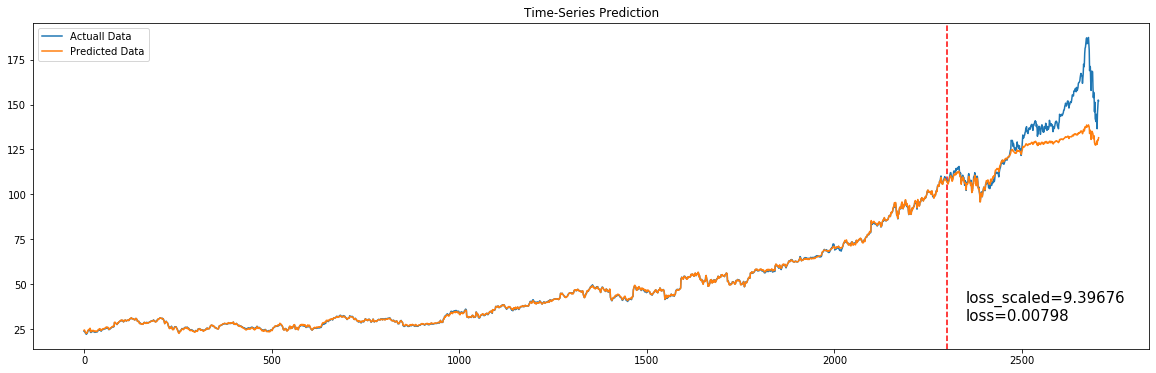

In [34]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

outputs = lstm1.forward(X_test_tensors_final)
loss = criterion(outputs, y_test_tensors)
mse = loss.item()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

mse_scaled=0
for i in range(len(dataY_plot)-2300):
    mse_scaled += abs(dataY_plot[2300+i][0] - data_predict[2300+i][0])
mse_scaled /= len(dataY_plot)-2300

plt.figure(figsize=(20,6)) #plotting
plt.axvline(x=2300, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.text(2350, 30, 'loss='+str(mse)[:7], fontsize=15)
plt.text(2350, 40, 'loss_scaled='+str(mse_scaled)[:7], fontsize=15)
plt.legend()
plt.show() 


# Подбор параметров 2

In [35]:
df_X_ss = ss.transform(data.iloc[2300:-1, :-1]) #old transformers
df_y_mm = mm.transform(data.iloc[2301:, -1:]) #old transformers


df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 


results = []
for ld in [16, 32, 64, 128, 256]:
    for hs in [4, 8, 16, 32]:
        lstm1 = LSTM1(num_classes, input_size, hs, num_layers, X_train_tensors_final.shape[1], ld) #our lstm class
        criterion = torch.nn.MSELoss()    # mean-squared error for regression
        optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 
        
        for epoch in range(num_epochs):
            outputs = lstm1.forward(X_train_tensors_final) #forward pass
            optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
            # obtain the loss function
            loss = criterion(outputs, y_train_tensors)
 
            loss.backward() #calculates the loss of the loss function
 
            optimizer.step() #improve from loss, i.e backprop
        
        outputs = lstm1.forward(X_test_tensors_final)
        loss = criterion(outputs, y_test_tensors)
        mse = loss.item()
        results.append([ld, hs, mse])
        print("linear_dim = %d | hidden_size = %d | mse = %1.5f" % (ld, hs, mse))
        

linear_dim = 16 | hidden_size = 8 | mse = 0.01554
linear_dim = 16 | hidden_size = 16 | mse = 0.00846
linear_dim = 16 | hidden_size = 32 | mse = 0.00122
linear_dim = 32 | hidden_size = 8 | mse = 0.00931
linear_dim = 32 | hidden_size = 16 | mse = 0.00199
linear_dim = 32 | hidden_size = 32 | mse = 0.00291
linear_dim = 64 | hidden_size = 8 | mse = 0.01161
linear_dim = 64 | hidden_size = 16 | mse = 0.00965
linear_dim = 64 | hidden_size = 32 | mse = 0.00287
linear_dim = 128 | hidden_size = 8 | mse = 0.00451
linear_dim = 128 | hidden_size = 16 | mse = 0.00930
linear_dim = 128 | hidden_size = 32 | mse = 0.00190


In [36]:
res_df = pd.DataFrame(results, columns =['ld', 'hs', 'mse'])
best = res_df[res_df.mse == res_df.mse.min()]
print(best)
best = best.to_numpy()

   ld  hs       mse
2  16  32  0.001223


In [37]:
lstm1 = LSTM1(num_classes, input_size, int(best[0][1]), num_layers, X_train_tensors_final.shape[1], int(best[0][0])) #our lstm class 
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 



In [38]:
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
 
    loss.backward() #calculates the loss of the loss function
 
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 



Epoch: 0, loss: 0.07788
Epoch: 100, loss: 0.00054
Epoch: 200, loss: 0.00032
Epoch: 300, loss: 0.00020
Epoch: 400, loss: 0.00012
Epoch: 500, loss: 0.00007
Epoch: 600, loss: 0.00005
Epoch: 700, loss: 0.00003
Epoch: 800, loss: 0.00002
Epoch: 900, loss: 0.00002


In [39]:
df_X_ss = ss.transform(data.iloc[:, :-1]) #old transformers
df_y_mm = mm.transform(data.iloc[:, -1:]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 



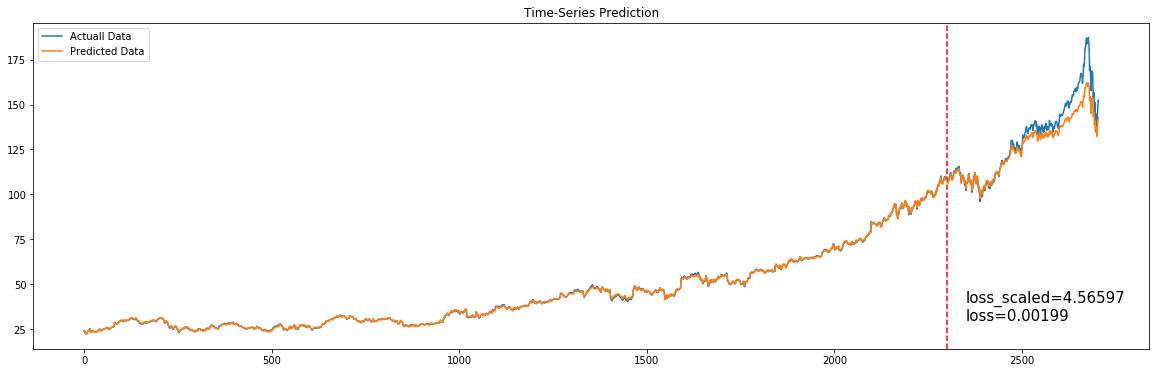

In [40]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

outputs = lstm1.forward(X_test_tensors_final)
loss = criterion(outputs, y_test_tensors)
mse = loss.item()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

mse_scaled=0
for i in range(len(dataY_plot)-2300):
    mse_scaled += abs(dataY_plot[2300+i][0] - data_predict[2300+i][0])
mse_scaled /= len(dataY_plot)-2300

plt.figure(figsize=(20,6)) #plotting
plt.axvline(x=2300, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.text(2350, 30, 'loss='+str(mse)[:7], fontsize=15)
plt.text(2350, 40, 'loss_scaled='+str(mse_scaled)[:7], fontsize=15)
plt.legend()
plt.show() 

# Обработка данных 3

Попробуем теперь оставить только цены акции

In [41]:
comp_balance = balance[balance['Ticker'] == 'MSFT'].drop(columns=['Ticker', 'SimFinId'])
comp_balance = comp_balance.rename(columns={'Report Date' : 'Date'})
comp_price = prices[prices['Ticker'] == 'MSFT'].drop(columns=['Ticker', 'SimFinId'])

data = pd.merge(comp_price, comp_balance, on='Date', how='outer')
data = data.dropna(subset=['Open'])
dividend = data['Dividend']

data = data.drop(columns=['Dividend', 'Currency', 'Fiscal Period', 'Publish Date', 'Restated Date'])
#
data = data.interpolate(method='linear', limit_direction='forward', axis=0)
data = data.drop(columns=['Treasury Stock'])

data = data.dropna()
#Логично дивиденды заполнить нулями, так как их не было
data['Dividend'] = dividend.fillna(0)
data = data.reset_index()
data = data.drop(columns=['index', 'Fiscal Year', 'Shares (Basic)', 'Shares (Diluted)', 'Volume'])
data = data.drop(columns=['Cash, Cash Equivalents & Short Term Investments', 'Total Assets', 'Total Liabilities'])
data = data.drop(columns=['Retained Earnings', 'Total Equity'])
data = data.drop(columns=['Inventories', 'Share Capital & Additional Paid-In Capital', 'Payables & Accruals', 'Shares Outstanding', 'Accounts & Notes Receivable', 'Close'])
data = data.drop(columns=['Property, Plant & Equipment, Net', 'Long Term Investments & Receivables', 'Other Long Term Assets', 'Total Noncurrent Assets', 'Total Current Assets'])
data = data.drop(columns=['Total Noncurrent Liabilities', 'Total Current Liabilities', 'Total Liabilities & Equity', 'Short Term Debt', 'Long Term Debt', 'Dividend', 'Adj. Close'])
data['Date'] = data['Date'].apply(lambda dt: datetime.datetime.strptime(dt, "%Y-%m-%d").strftime("%d.%m.%Y"))

In [42]:
data

,Date,Open,Low,High
0,30.06.2009,23.97,23.63,24.24
1,01.07.2009,24.05,23.96,24.30
2,02.07.2009,23.76,23.21,24.04
3,06.07.2009,23.21,22.87,23.28
4,07.07.2009,23.08,22.46,23.14
...,...,...,...,...
2700,23.03.2020,137.01,132.52,140.57
2701,24.03.2020,143.75,141.27,149.60
2702,25.03.2020,148.91,144.44,154.33
2703,26.03.2020,148.40,148.37,156.66


In [43]:
data = data.set_index('Date')
dim = len(data.columns)
data['Target'] = (data['Low'] + data['High'])*0.5
X = data.iloc[:, :-1]
X = X.iloc[:-1]
y = data.iloc[:, -1:]
y = y.iloc[1:]

In [44]:
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 


X_train = X_ss[:2300, :]
X_test = X_ss[2300:, :]

y_train = y_mm[:2300, :]
y_test = y_mm[2300:, :]


X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 


X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

In [45]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([2300, 1, 3]) torch.Size([2300, 1])
Testing Shape torch.Size([404, 1, 3]) torch.Size([404, 1])


# Обучение 3

In [46]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = dim #number of features
hidden_size = 4 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
linear_dim = 128 #dim of linear layers

num_classes = 1 #number of output classes 

In [47]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1], linear_dim) #our lstm class 
lstm1
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 


In [48]:
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
 
    loss.backward() #calculates the loss of the loss function
 
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 


Epoch: 0, loss: 0.01648
Epoch: 100, loss: 0.00008
Epoch: 200, loss: 0.00003
Epoch: 300, loss: 0.00002
Epoch: 400, loss: 0.00002
Epoch: 500, loss: 0.00002
Epoch: 600, loss: 0.00001
Epoch: 700, loss: 0.00001
Epoch: 800, loss: 0.00001
Epoch: 900, loss: 0.00001


In [49]:
df_X_ss = ss.transform(data.iloc[:, :-1]) #old transformers
df_y_mm = mm.transform(data.iloc[:, -1:]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 



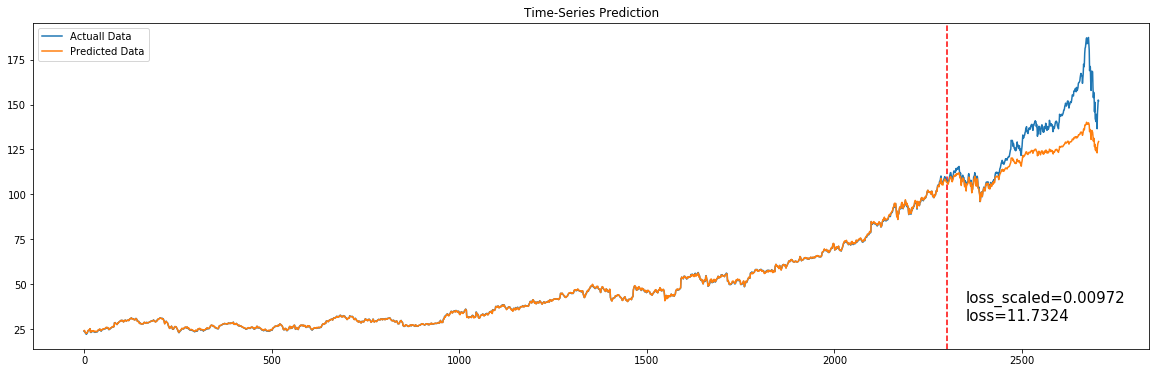

In [50]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

outputs = lstm1.forward(X_test_tensors_final)
loss = criterion(outputs, y_test_tensors)
mse = loss.item()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

mse_scaled=0
for i in range(len(dataY_plot)-2300):
    mse_scaled += abs(dataY_plot[2300+i][0] - data_predict[2300+i][0])
mse_scaled /= len(dataY_plot)-2300

plt.figure(figsize=(20,6)) #plotting
plt.axvline(x=2300, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.text(2350, 30, 'loss='+str(mse_scaled)[:7], fontsize=15)
plt.text(2350, 40, 'loss_scaled='+str(mse)[:7], fontsize=15)
plt.legend()
plt.show() 

# Подбор параметров 3

In [51]:
df_X_ss = ss.transform(data.iloc[2300:-1, :-1]) #old transformers
df_y_mm = mm.transform(data.iloc[2301:, -1:]) #old transformers


df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 


results = []
for ld in [16, 32, 64, 128, 256]:
    for hs in [4, 8, 16, 32]:
        lstm1 = LSTM1(num_classes, input_size, hs, num_layers, X_train_tensors_final.shape[1], ld) #our lstm class
        criterion = torch.nn.MSELoss()    # mean-squared error for regression
        optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 
        
        for epoch in range(num_epochs):
            outputs = lstm1.forward(X_train_tensors_final) #forward pass
            optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
            # obtain the loss function
            loss = criterion(outputs, y_train_tensors)
 
            loss.backward() #calculates the loss of the loss function
 
            optimizer.step() #improve from loss, i.e backprop
     
        outputs = lstm1.forward(X_test_tensors_final)
        loss = criterion(outputs, y_test_tensors)
        mse = loss.item()
        results.append([ld, hs, mse])
        print("linear_dim = %d | hidden_size = %d | mse = %1.5f" % (ld, hs, mse))

linear_dim = 16 | hidden_size = 8 | mse = 0.02084
linear_dim = 16 | hidden_size = 16 | mse = 0.00924
linear_dim = 16 | hidden_size = 32 | mse = 0.00575
linear_dim = 32 | hidden_size = 8 | mse = 0.01727
linear_dim = 32 | hidden_size = 16 | mse = 0.00201
linear_dim = 32 | hidden_size = 32 | mse = 0.00162
linear_dim = 64 | hidden_size = 8 | mse = 0.01428
linear_dim = 64 | hidden_size = 16 | mse = 0.00840
linear_dim = 64 | hidden_size = 32 | mse = 0.00184
linear_dim = 128 | hidden_size = 8 | mse = 0.01019
linear_dim = 128 | hidden_size = 16 | mse = 0.00559
linear_dim = 128 | hidden_size = 32 | mse = 0.00242


In [52]:
res_df = pd.DataFrame(results, columns =['ld', 'hs', 'loss'])
best = res_df[res_df.loss == res_df.loss.min()]
print(best)
best = best.to_numpy()

   ld  hs      loss
5  32  32  0.001617


In [53]:
lstm1 = LSTM1(num_classes, input_size, int(best[0][1]), num_layers, X_train_tensors_final.shape[1], int(best[0][0])) #our lstm class 
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 


In [54]:
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
 
    loss.backward() #calculates the loss of the loss function
 
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


Epoch: 0, loss: 0.04484
Epoch: 100, loss: 0.00073
Epoch: 200, loss: 0.00004
Epoch: 300, loss: 0.00002
Epoch: 400, loss: 0.00002
Epoch: 500, loss: 0.00001
Epoch: 600, loss: 0.00001
Epoch: 700, loss: 0.00001
Epoch: 800, loss: 0.00001
Epoch: 900, loss: 0.00001


In [55]:
df_X_ss = ss.transform(data.iloc[:, :-1]) #old transformers
df_y_mm = mm.transform(data.iloc[:, -1:]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 


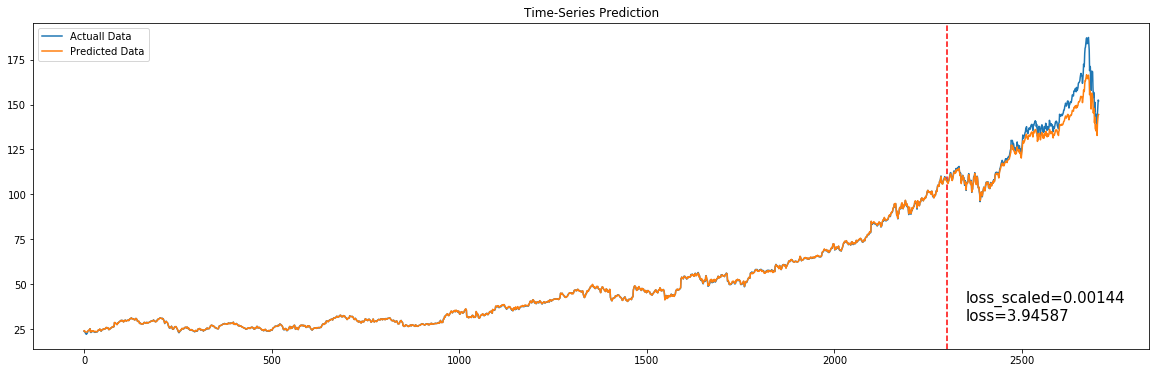

In [56]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

outputs = lstm1.forward(X_test_tensors_final)
loss = criterion(outputs, y_test_tensors)
mse = loss.item()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

mse_scaled=0
for i in range(len(dataY_plot)-2300):
    mse_scaled += abs(dataY_plot[2300+i][0] - data_predict[2300+i][0])
mse_scaled /= len(dataY_plot)-2300

plt.figure(figsize=(20,6)) #plotting
plt.axvline(x=2300, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.text(2350, 30, 'loss='+str(mse_scaled)[:7], fontsize=15)
plt.text(2350, 40, 'loss_scaled='+str(mse)[:7], fontsize=15)
plt.legend()
plt.show() 